# Some System Identification

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S46_logistics_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

```{index} learning; system identification
```

> Robots can "learn" measurement and motion models.

<img src="Figures4/S46-Warehouse_robots-09.jpg" alt="Splash image with various evolutions of warehouse robots" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

In this section, we will limit ourselves to learning linear conditional Gaussians from data.
In Section 4.1, we discussed three different ways to represent densities over a two dimensional state
$x\in\mathbb{R}^2$: Gaussian densities, finite element approximations, and samples.
In Section 4.4 we presented three different Bayes filters stemming from each of these choices.
However, in each case the motion model was the same: a conditional Gaussian where the mean was a *linear* function of the previous state. In this section we will investigate whether we can learn both the linear mapping as well as the noise parameters from data.

## Maximum Likelihood Parameter Estimation

```{index} maximum likelihood, system matrix
```
Let us first consider a one dimensional system (i.e., $x_k \in \mathbb{R}$ is a scalar),
and a sensor model that is linear with additive Gaussian noise,
\begin{equation}
z_k = h(x_k) + n_k = C x_k + n_k,
\end{equation}
where $C$ is a **system matrix**, and $n_k$ denotes zero-mean, Gaussian noise with covariance $R$. 

In the one dimensional case, both $C$ and $R=\sigma^2$ are scalars, and estimating them will be similar to the Gaussian parameter estimation from [Section 2.6](#sec:sorter-learning). Remember that there we estimated a sample mean $\hat{\mu}$ from a set of $N$ data points, by simply computing the average of the data values:
\begin{equation}
\hat{\mu} = \frac{1}{N} \sum_i z_i.
\end{equation}

```{index} pair: negative log likelihood; nll
```
The underlying reason is that this minimizes the *negative log likelihood* (nll) of $\mu$ given the data $X$ by
\begin{equation}
\hat{\mu} = \arg \min_\mu \sum_i \text{nll}(\mu; z_i) = \arg \min_\mu \sum_i \frac{1}{2\sigma^2} (\mu - z_i)^2,
\end{equation}
hence this is a *maximum likelihood* (ML) estimator of $\mu$.

We now focus on adapting this same idea to estimating the (scalar) system matrix $C$.
Suppose we are given a set of ground truth values $\{x_k\}$ for the state along with corresponding
measurement values $\{z_k\}$.
If we generalize the scheme from Chapter 2, the negative log likelihood of $C$ given the data for our measurement model becomes
\begin{equation}
\hat{C} = \arg \min_C \sum_k \text{nll}(C; x_k, z_k) = \arg \min_C \sum_k \frac{1}{2\sigma^2} (C x_k - z_k)^2.
\end{equation}
Taking the derivative with respect to $C$ and setting to zero we have
\begin{equation}
\sum_k x_k(\hat{C} x_k - z_k) = 0,
\end{equation}
yielding
\begin{equation}
\hat{C} = \frac{\sum_k x_k z_k}{\sum_k x_k^2}.
\end{equation}

Note that above the value of $\sigma$ did not affect the value of the estimate $\hat C$. Once we have that estimate in hand, however, we can use it to estimate the variance $\sigma^2$ by using
\begin{equation}
\widehat{\sigma^2} = \frac{1}{N-1} \sum_k (\hat{C} x_k - z_k)^2.
\end{equation} 

## ML Code Example
Consider a one dimensional version of the warehouse problem in which the robot
moves only along the $x$ axis.
In Figure [1](#fig:location_vs_measured_location) we simulate some states randomly from the $x$ direction in the warehouse, i.e., between 0 and 100 meters, and then the measurement $z$ from those sampled $x$ coordinates, and then plot them against each other.

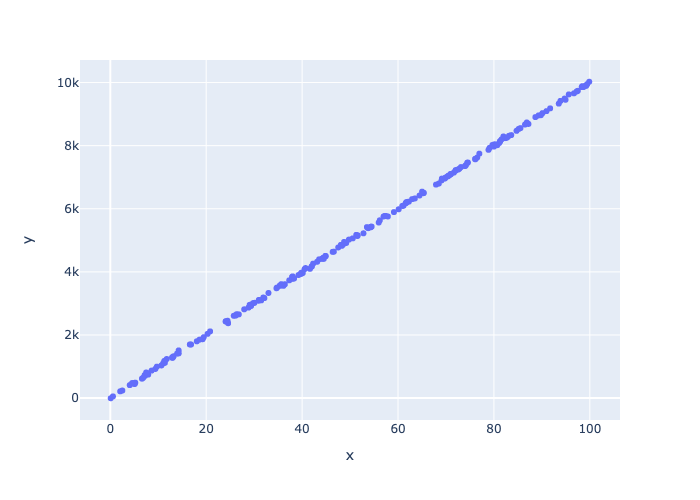

In [ ]:
#| caption: Plot of location versus measured location. 
#| label: fig:location_vs_measured_location
C = 100 # scaling from meters to centimeters
R = 30**2  # 30 centimeter standard deviation
N = 200  # number of samples
X = rng.uniform(low=0, high=100, size=N) # warehouse length
Z = rng.normal(C*X, np.sqrt(R))
px.scatter(x=X, y=Z)

It is pretty clear that the slope is 100. Can our math corroborate?

In [ ]:
estimated_C = np.sum(X*Z) / np.sum(X*X)
print(f"estimated C = {estimated_C} (cm/m)")

estimated C = 100.03303142771483 (cm/m)


{raw:tex}`\noindent`
That estimate $\hat C$ is quite close to the correct value. The variance and standard deviation are likewise well estimated:

In [ ]:
estimated_R = np.sum(np.square(estimated_C*X-Z))/(N-1)
print(f"estimated R={estimated_R} (cm^2), stddev={np.sqrt(estimated_R)} (cm)")

estimated R=966.2397937984271 (cm^2), stddev=31.084397915971078 (cm)


## Extending to multi-dimensional systems

> For multi-dimensional systems, if the undertainties for the various dimensions are independent, we can solve the parameter estimation problems independently.

In the warehouse example, for the GPS-like sensor, we assumed that $x$ and $y$ were measured directly,
that the noise on them was uncorrelated, and that the noise for each dimension had variance $\sigma^2$.
When this assumption holds, the parameter estimation problem is to estimate the
independent 1D scaling factors $C_x$ and $C_y$, and the scalar variance $\sigma^2$.
We can use the code above to do so for $x$ and $y$ independently.

## Multivariate Linear Regression

```{index} linear regression
```
For more general measurement processes or motion models, we typically need heavier machinery. The scalar case above is an instance of *linear regression*, and it can be generalized to the multivariate case. Let us assume a multivariate linear measurement model
\begin{equation}
z_k = H x_k + n_k
\end{equation}
where now $z_k\in\mathbb{R}^m$, $x_k\in\mathbb{R}^n$, and $H$ an $m \times n$ matrix. Again, $n_k$ is assumed zero mean Gaussian, with covariance matrix $R$.

```{index} isotropic noise
```
The negative log likelihood of $H$ given the data for our measurement model is
\begin{equation}
\hat{H} = \arg \min_H \sum_k \text{nll}(H; x_k, z_k) = \arg \min_H \sum_k \frac{1}{2} (H x_k - z_k)^T R^{-1}(H x_k - z_k).
\end{equation}

Unfortunately, the estimation process for arbitrary $R$ is out of scope for this text. But if we assume *isotropic* noise with covariance matrix $I \sigma^2$, then the optimization problem simplifies to 
\begin{equation}
\hat{H} = \arg \min_H \frac{1}{2\sigma^2} \sum_k \sum_i (H_i x_k - z_{ki})^2,
\end{equation}
where $H_i$ is the $i^th$ row of $H$. Making use of the fact that the scalar $H_i x_k$ can be re-written as $x_k^T H_i^T$, and then setting the derivative with respect to $H_i^T$ to zero we have, for all $i$:
\begin{equation}
\sum_k x_k (x_k^T \hat{H}_i^T - z_{ki}) = 0,
\end{equation}
yielding the following expression for the $i^{th}$ row of $H$:
\begin{equation}
\hat{H}_i^T = (\sum_k x_k x_k^T)^{-1} \sum_k x_k z_{ki}.
\end{equation}

Note the resemblance with the scalar case, but be mindful that the quantity in parentheses is an $n\times n$ matrix whose inverse will exist only if its rank is equal to the dimensionality of the system, $n$.
This rank condition is farily easy to satisfy, and is essentially a requirement that the data set
be sufficiently rich.
It is interesting to note that the $i^{th}$ row of $\hat{H}$ is formed as sum of the input vectors $x_k$, weighted by the $i^{th}$ element of the measurement. Finally, we can collect the above for all $i$ and write:
\begin{equation}
\hat{H}^T = (\sum_k x_k x_k^T)^{-1} \sum_k x_k z_k^T.
\end{equation}

After this, we can again recover the variance $\sigma^2$ by
\begin{equation}
\widehat{\sigma^2} = \frac{1}{(m N-m n)} \sum_k \sum_i |\hat{H}_i x_k - z_{ki}|^2.
\end{equation}
in which $N$ is the number of data points.
Above we would divide by $m N$ as that is how many elements there are in the double sum. However, to get an unbiased estimate we need to subtract $mn$ from the denominator as that is how many entries we already estimated with $H$.

## Multivariate ML Code Example
Let us simulate some *2D* states randomly in the warehouse, and multiply with a random $3\times 2$ $H$ matrix:

In [ ]:
H = np.array([[10,20],[30,40],[50,60]]) # scaling from meters to centimeters
R = 30**2  # 30 centimeter standard deviation
N = 200  # number of samples
X = rng.uniform(low=[0,0], high=[100,50], size=(N,2)).T # warehouse dimensions
Z = rng.normal(H @ X, np.sqrt(R))

The multivariate estimator:

In [ ]:
H_transpose = np.linalg.inv(X @ X.T) @ (X @ Z.T)
H_optimal = H_transpose.T
print(f"H_optimal=\n{np.round(H_optimal,2)}")

H_optimal=
[[10.1  19.86]
 [30.06 39.85]
 [50.03 59.92]]


Pretty close! And the estimate for the standard deviation:

In [ ]:
np.sqrt(np.sum(np.square(H_optimal @ X - Z))/(3*N-6))

29.935915630018545

## Application: Motion Model Estimation

> Linear regression can be used to estimate all of the parameters of a general linear motion model.

Assuming we have a dataset of triplets $x_k, u_k, x_{k+1}$, i.e., the current state $x_k\in\mathbb{R}^n$, the control $u_k\in\mathbb{R}^p$, and the next state $x_{k+1}\in\mathbb{R}^n$. Note the similarities with the reinforcement learning setup in Section 3.6! If we assume a *linear process model* then we should have:
\begin{equation}
x_{k+1} = A x_k + B u_k + w_k
\end{equation}
where typically the covariance on the *process noise* $w_k$ is denoted as $Q$. We only have to note that we can write this in the form needed by the multivariate ML estimator, as
\begin{equation}
x_{k+1} = \begin{bmatrix} A & B \end{bmatrix} \begin{bmatrix} x_k \\ u_k \end{bmatrix} + w_k
\end{equation}

Again, we generate some random states, controls, and next states:

In [ ]:
N = 500  # number of samples
X = rng.uniform(low=[0,0], high=[100,50], size=(N,2)).T # states
U = rng.normal(scale=5, size=(N,2)).T # controls, zero mean, 5m standard deviation
A = np.eye(2)
B = np.eye(2)
R = 4  # 2 meter standard deviation
Z = rng.normal(A @ X + B @ U, np.sqrt(R)) # the next state

The multivariate estimator:

In [ ]:
XU = np.vstack([X,U])
XU.shape

(4, 500)

In [ ]:
AB_transpose = np.linalg.inv(XU @ XU.T) @ (XU @ Z.T)
AB_optimal = AB_transpose.T
A_optimal, B_optimal = AB_optimal[:,:2], AB_optimal[:,2:]
print(f"A_optimal=\n{np.round(A_optimal,2)}")
print(f"B_optimal=\n{np.round(B_optimal,2)}")

A_optimal=
[[ 1. -0.]
 [-0.  1.]]
B_optimal=
[[ 1.01 -0.02]
 [-0.02  0.99]]


Pretty close! And the estimate for the standard deviation (note the changed denominator!):

In [ ]:
np.sqrt(np.sum(np.square(AB_optimal @ XU - Z))/(2*N-8))

1.9365058899020415

## Expectation Maximization

> We can estimate unknown parameters even if we don't have access to ground truth state values.

The above assumed that we had perfect knowledge of the state $x_k$ when collecting data for the learning process. But what if we only had access to the controls $U$ and measurements $Z$? A natural idea is to try and estimate the states with the techniques from Section 4.4, and then somehow use the posterior density $p(X|U,Z)$ to estimate any unknown parameters $\Theta$. However, the estimation problem itself *uses* the parameters, so we have a chicken and egg problem!

```{index} pair: expectation-maximization; EM algorithm
```
The **expectation-maximization** or **EM algorithm** is an algorithm that allows us to estimate measurement and motion models *even when the state is only observed from measurements*. We do need *some* initial estimate $\Theta^1$ for the parameters $\Theta$, and the idea is to then alternate between two steps:
- E-step: calculate the density $p(X|U,Z;\Theta^t)$ on hidden states $X$, *given* the guess $\Theta^t$.
- M-Step: maximize the *expected* log-likelihood with respect to $\Theta^{t+1}$ under this density.

```{index} Monte Carlo EM
```
We do not discuss the detailed derivations here, but we do want to mention that a particularly simple variant of EM is to use a particle filter in the E-step. We can then simply "pretend" that the samples form a large dataset, and perform the above estimation procedures in the M-step. This is an instance of a so-called **Monte Carlo EM** algorithm, and the amazing fact is that this then actually converges to an maximum-likelihood estimate for the unknown parameters $\Theta$.